In [35]:
#imports
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Problem 1

In [36]:
img = Image.open('./Lenna.png')

# Convert the image to grayscale using 'L' mode
grayscale_img = img.convert('L')

In [37]:
"""Downsample the image by taking every other pixel in both x and y directions."""
img_array = np.array(grayscale_img)

# Downsample by taking every other pixel in both dimensions
downsampled_img_array = img_array[::2, ::2]

# Convert back to PIL Image
downsampled_img = Image.fromarray(downsampled_img_array)

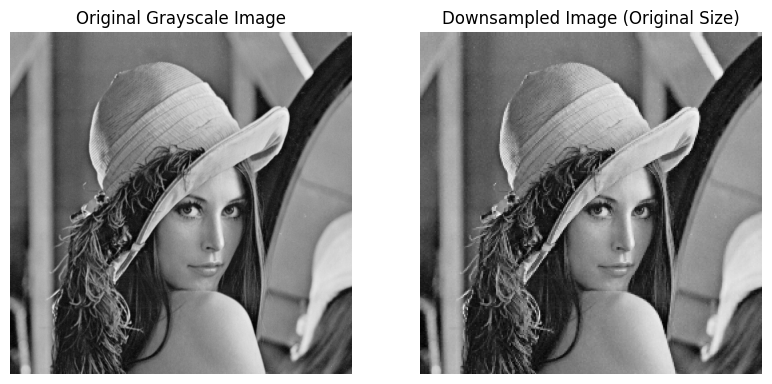

In [38]:
"""Comparison 1"""
plt.figure(figsize=(15, 5))

# Display original grayscale image
plt.subplot(1, 3, 1)
plt.title("Original Grayscale Image")
plt.imshow(grayscale_img, cmap='gray')
plt.axis('off')

# Display downsampled image (scaled to original size for comparison)
plt.subplot(1, 3, 2)
plt.title("Downsampled Image (Original Size)")
plt.imshow(downsampled_img, cmap='gray')
plt.axis('off')

plt.show()

In [39]:
def upsample_image(downsampled_img, times):
    """Upsample the image by inserting empty pixels between each pixel."""
    img_array = np.array(downsampled_img)
    
    for _ in range(times):
        # Get current dimensions
        h, w = img_array.shape[0], img_array.shape[1]
        
        # Create a new array with twice the size, filled with zeros (empty pixels)
        upsampled_img_array = np.zeros((h * 2, w * 2), dtype=img_array.dtype)
        
        # Copy original pixels into the upsampled array at every other index
        upsampled_img_array[::2, ::2] = img_array
        
        # Update img_array for next iteration if upsampled multiple times
        img_array = upsampled_img_array
    
    # Convert back to PIL Image
    upsampled_img = Image.fromarray(upsampled_img_array)
    
    return upsampled_img

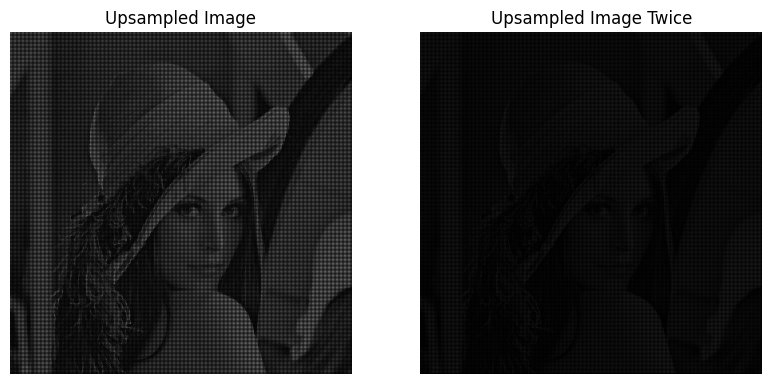

In [40]:
"""Comparison 2"""
plt.figure(figsize=(15, 5))

# Display upsampled image
plt.subplot(1, 3, 1)
plt.title("Upsampled Image")
plt.imshow(upsample_image(downsampled_img, 1), cmap='gray')
plt.axis('off')

# Display upsampled twice image
plt.subplot(1, 3, 2)
plt.title("Upsampled Image Twice")
plt.imshow(upsample_image(downsampled_img, 2), cmap='gray')
plt.axis('off')

plt.show()

# Problem 2

In [41]:
def myGaussianSmoothing(I, k, s):
    """
    Apply Gaussian smoothing to an image I with kernel size k and scaling parameter s (sigma).
    
    Parameters:
    - I: Input image
    - k: Kernel size (should be an odd number)
    - s: Standard deviation for the Gaussian kernel (sigma)
    
    Returns:
    - I_smooth: Smoothed image
    """
    # Ensure kernel size is odd
    if k % 2 == 0:
        raise ValueError("Kernel size should be an odd number")
    
    # Apply Gaussian Blur using OpenCV's GaussianBlur function
    I_smooth = cv2.GaussianBlur(I, (k, k), s)
    return I_smooth

In [42]:
def plot_images(original, smoothed_images, titles):
    """ Utility function to plot the original and smoothed images. """
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.subplot(2, len(smoothed_images)//2 + 1, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot smoothed images
    for i, (img, title) in enumerate(zip(smoothed_images, titles)):
        plt.subplot(2, len(smoothed_images)//2 + 1, i + 2)
        plt.imshow(img, cmap='gray')
        plt.title(title)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

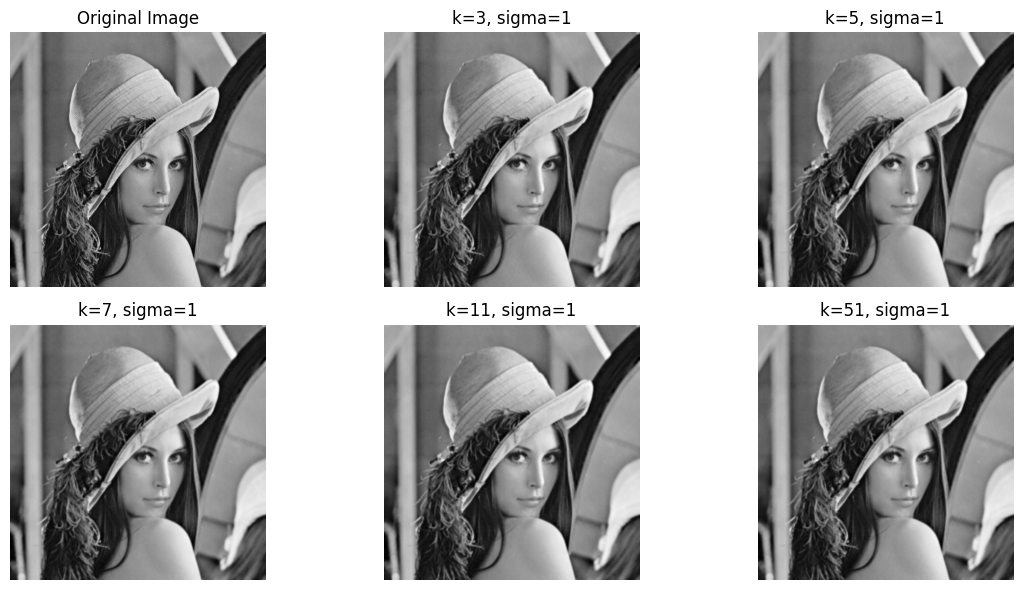

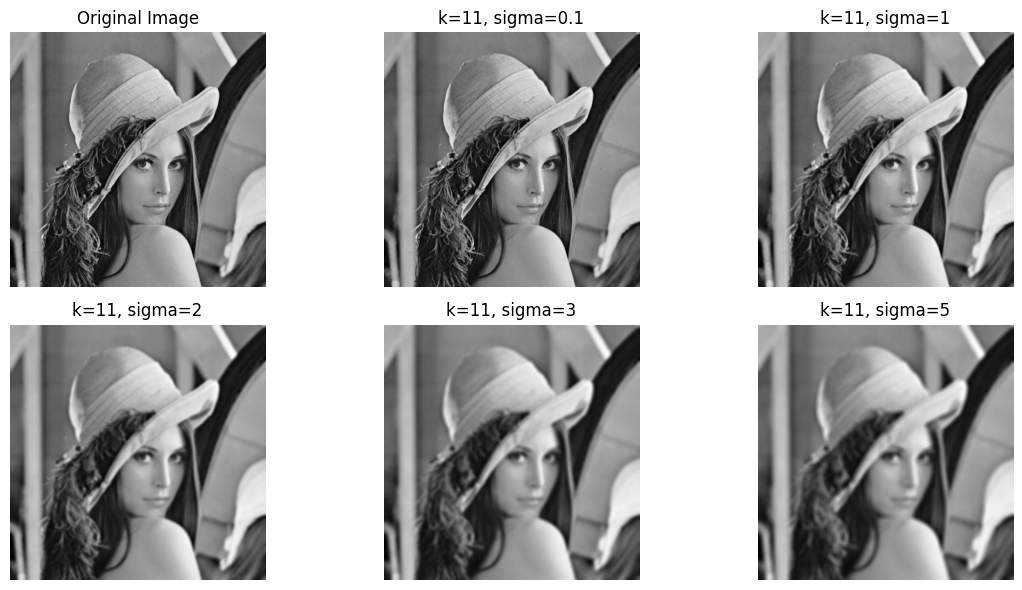

In [43]:
I = cv2.imread('./Lenna.png', cv2.IMREAD_GRAYSCALE)  # Load a grayscale image

# Part 1: Varying kernel size with fixed sigma
kernel_sizes = [3, 5, 7, 11, 51]
sigma = 1
smoothed_images_k = [myGaussianSmoothing(I, k, sigma) for k in kernel_sizes]
titles_k = [f"k={k}, sigma={sigma}" for k in kernel_sizes]

# Part 2: Varying sigma with fixed kernel size
kernel_size = 11
sigmas = [0.1, 1, 2, 3, 5]
smoothed_images_s = [myGaussianSmoothing(I, kernel_size, s) for s in sigmas]
titles_s = [f"k={kernel_size}, sigma={s}" for s in sigmas]

# Plot results for varying kernel sizes
plot_images(I, smoothed_images_k, titles_k)

# Plot results for varying sigma
plot_images(I, smoothed_images_s, titles_s)

# Problem 3

In [44]:
def median_filter(image, kernel_size):
    """Apply median filter to the image."""
    padded = np.pad(image, kernel_size // 2, mode='edge')
    result = np.zeros_like(image)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            window = padded[i:i+kernel_size, j:j+kernel_size]
            result[i, j] = np.median(window)
    return result

In [45]:
def process_image(downsampled_img, upsample_times, gaussian_k, gaussian_sigma, median_k):
    """Process the image: upsample, apply Gaussian smoothing, and median filtering."""
    # Upsample
    upsampled = upsample_image(downsampled_img, upsample_times)
    
    # Convert to numpy array if it's not already
    upsampled_array = np.array(upsampled)
    
    # Gaussian smoothing
    smoothed = myGaussianSmoothing(upsampled_array, gaussian_k, gaussian_sigma)
    
    # Median filtering
    median_filtered = median_filter(smoothed, median_k)
    
    return upsampled_array, smoothed, median_filtered

In [46]:
def plot_results(original, upsampled, smoothed, median_filtered):
    """Plot the original, upsampled, smoothed, and median filtered images."""
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(original, cmap='gray')
    plt.title("Original Downsampled")
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(upsampled, cmap='gray')
    plt.title("Upsampled")
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(smoothed, cmap='gray')
    plt.title("Gaussian Smoothed")
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(median_filtered, cmap='gray')
    plt.title("Median Filtered")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

In [47]:
# Process the image
upsampled, smoothed, median_filtered = process_image(
    downsampled_img, 
    upsample_times=1, 
    gaussian_k=11, 
    gaussian_sigma=1, 
    median_k=3
)


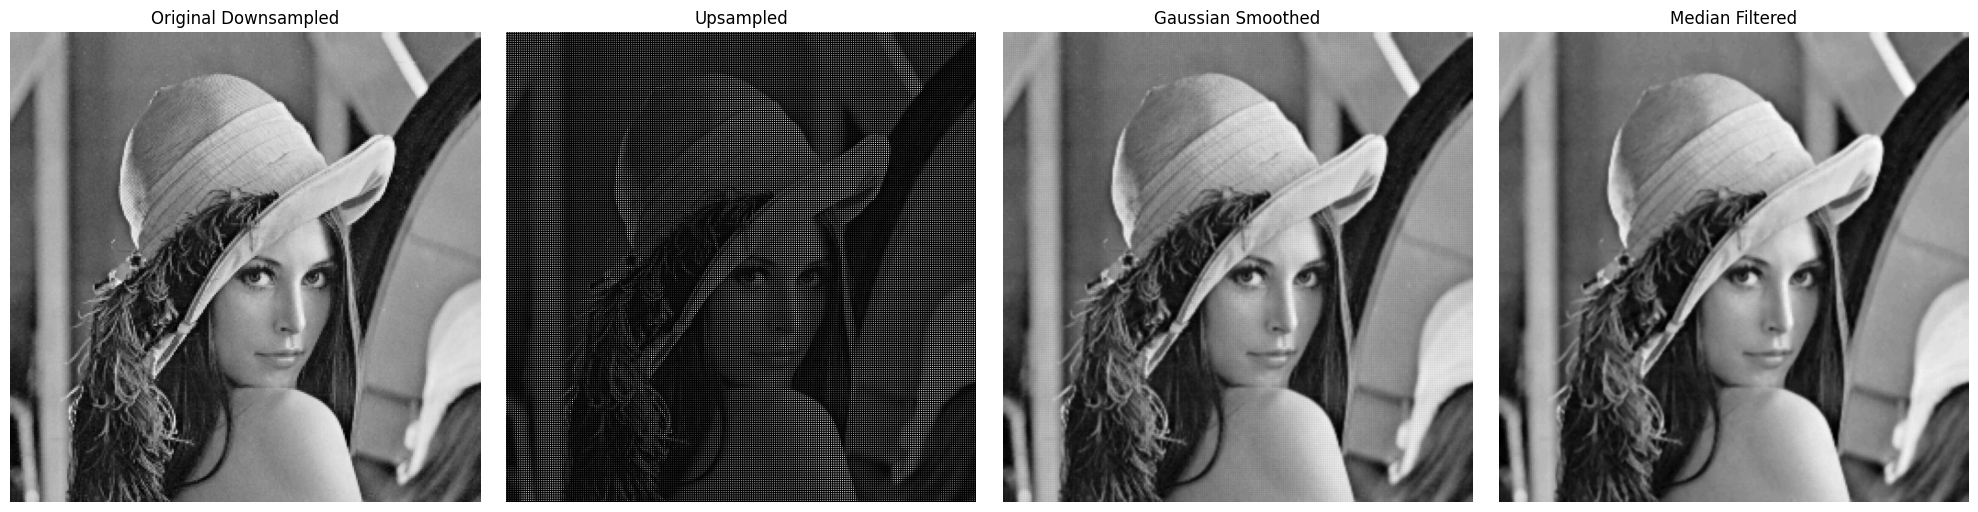

In [48]:
# Plot results
plot_results(downsampled_img, upsampled, smoothed, median_filtered)